<a href="https://colab.research.google.com/github/tejatanush/Face-Recognition/blob/main/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Description:**
This face recognition model is designed to identify individuals based on facial images. It employs a **Siamese network architecture**, which is particularly effective for tasks involving similarity comparison between pairs of inputs. The model is trained to distinguish between the facial features of different individuals and is capable of predicting the identity of a person from a given image.

# 1. Import Libraries

In [100]:
import numpy as np
import cv2
import dlib
import matplotlib.pyplot as plt
import tensorflow as tf

# 2. Detect face in an image
Here we use Haar cascade classifiers to detect face in an image.The function here **detect_face** will take image as input and then detect face in that image after converting to gray image. Co-ordinates of fae in an image are stored in face variable. If  more than one face is detected first face will be taken in to consideration.

In [101]:
faceclassifier=cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
def detect_face(image):
  #image=cv2.imread(image)
  gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  faces=faceclassifier.detectMultiScale(gray,1.3,5)
  if faces is ():
    print("No faces found")
  if len(faces)>0:
    (x, y, w, h) = faces[0]
    face = image[y:y+h, x:x+w]
    face=cv2.resize(face,(128,128))
    return face



<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-101-71a4855df158>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if faces is ():


# 3. Make dataset to train images
Make a dataset with lables and face co-ordinates in that image using **detect_face** function.Ensure that face co-ordinates and approprite labels must be in same order.Here we want to train 5 persons to our model and we use just 2 images for every person.

In [102]:
face_images = []
labels = ["Abdul Kalam", "Rahul Dravid", "Mother Teresa", "Allu Arjun", "Virendra Shewag","Abdul Kalam", "Rahul Dravid", "Mother Teresa", "Allu Arjun", "Virendra Shewag"]
def faces(image_path):
  image = cv2.imread(image_path)
  face_image = detect_face(image)
  if face_image is not None:
    face_images.append(face_image)

faces("/content/abdul kalam 1.jpeg")
faces("/content/rahul dravid 1.jpeg")
faces("/content/mother teressa 1.jpeg")
faces("/content/allu arjun 1.jpeg")
faces("/content/virendra shewag 1.jpeg")
faces("/content/abdul kalam 2.jpg")
faces("/content/rahul dravid 2.jpeg")
faces("/content/mother teressa 2.jpeg")
faces("/content/allu arjun 2.jpeg")
faces("/content/virendra shewag 2.jpeg")

In [103]:
print(len(face_images))

10


# 4. Create pairs to train the model
Here we use siamese network for face recognition. So that as per siamese network if 2 images are same(positive) then it will be labeled as 1. If 2 images are different(negative) then labeled as 0. We make a list so that every image will paired up with another image so that the list will consists of pairs of images. The targets will be 1 or 0 based on pairs.

In [104]:
import numpy as np

def create_pairs(face_images, labels):
    pairs = []
    targets = []
    if len(face_images) != len(labels):
        print(f"Error: Mismatch between number of face images ({len(face_images)}) and labels ({len(labels)})")
        return None, None

    # Create positive pairs (same person)
    for i in range(len(face_images)):
        for j in range(i+1, len(face_images)):
            if labels[i] == labels[j]:  # Positive pair (same label)
                pairs.append([face_images[i], face_images[j]])
                targets.append(1)
            else:  # Negative pair (different label)
                pairs.append([face_images[i], face_images[j]])
                targets.append(0)

    return np.array(pairs), np.array(targets)

pairs, targets = create_pairs(face_images, labels)


 # 5.Build a model
 The siamese network will having same architecture for both the images with same weights and back propagation. Firstly there will be a feature extraction for every image in image pair.Then euclidean distance will be caluculated for both images in image pair.

In [105]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# Function to create the embedding model
def create_base_network(input_shape):
    input = Input(shape=input_shape)

    # Simple CNN for feature extraction
    x = Conv2D(64, (3, 3), activation='relu')(input)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    return Model(input, x)

# Siamese Network - input_shape = (128, 128, 3)
input_shape = (128, 128, 3)
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Create embeddings for both inputs
embedding_a = base_network(input_a)
embedding_b = base_network(input_b)

# Distance calculation (Euclidean distance)
def euclidean_distance(vectors):
    (feat_a, feat_b) = vectors
    sum_squared = K.sum(K.square(feat_a - feat_b), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

# Lambda layer to calculate distance
distance = Lambda(euclidean_distance)([embedding_a, embedding_b])

# Create final model
model = Model(inputs=[input_a, input_b], outputs=distance)


In [106]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_6 (Functional) │ (None, 256)            │     29,567,104 │ input_layer_10[0][0],  │
│                           │                        │                │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 1)              │              0 │ functional_6[0][0],    │
│                           │                        │                │ functional_6[1][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 29,567,104 (112.79 MB)

 Trainable params: 29,567,104 (112.79 MB)

 Non-trainable params: 0 (0.00 B)

Then model will be compiled with contrastive loss and adam optimizer with a learning rate of 0.0001. Then the model will be fitted in to pairs and their targets.

In [107]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define contrastive loss
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# Compile model
model.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=0.0001))

# Train the model
model.fit([pairs[:, 0], pairs[:, 1]], targets, batch_size=16, epochs=30)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 1709.3800
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 4091.2363
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 816.4595
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 273.3157
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 179.5192
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 236.5617
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 118.3344
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 68.5792
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 60.9151
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 47.2856
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - loss: 30.6706
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 17.5522
Epoch 13/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 10.6680
Epoch 14/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 10.0212
Epoch 15/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 13.8293
Epoch 16/30
3/3 ━━━━━━━━━━━━━━

# 6. Prediction of image
When an image is sent to recognize face from trained persons model will predict based on euclidean distance for every image on which model was trained. Based on minimum euclidean distance the model will finalize the recognized person name.

In [127]:
def predict(image_path):
    # Detect face
    image=cv2.imread(image_path)
    face = detect_face(image)
    if face is None:
        return "No face detected"

    face = np.expand_dims(face, axis=0)

    min_dist = float('inf')
    identity = None

    # Compare with stored embeddings
    for i, stored_face in enumerate(face_images):
        stored_face = np.expand_dims(stored_face, axis=0)
        dist = model.predict([face, stored_face])[0][0]

        if dist < min_dist:
            min_dist = dist
            identity = labels[i]
    plt.imshow(image)
    plt.text(x=125, y=0, s=identity, fontsize=12, color='red', ha='center', va='center')
    plt.show()
    print(min_dist)

    return identity


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


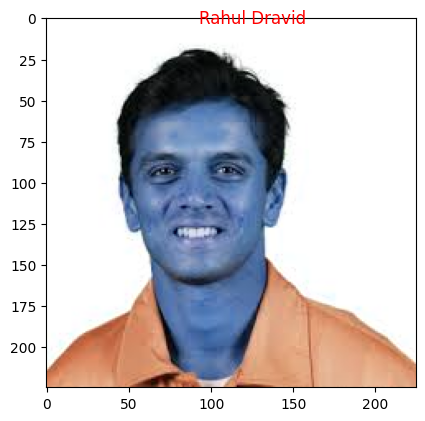

27.502201


'Rahul Dravid'

In [129]:
predict("/content/rahul dravid 3.jpeg")

Here the model predicts that the face in an image is rahul dravid with a min_distance of 27.502201 .